# 2020-11-27 • Permutation test for $p($connected$)$

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Mon 30 Nov** 2020, at 11:45 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/be0bf22bb1f0ba3df0b2a37bb90fee20d6696b50
) (Mon 30 Nov 2020, 11:02).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/support/notebook_init.py
A  notebooks/2020-11-11__unitlib.ipynb
 M setup.py
?? notebooks/2020-11-27__permutation_test.ipynb
```

In [3]:
tg = v.TimeGrid(T=10*minute, dt=0.1*ms);

## Generate VI signal

### Spike trains

'Network' definition.

In [4]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [5]:
f_spike = 20 * Hz;

In [6]:
gen_st = v.generate_Poisson_spike_train

v.fix_rng_seed()

In [7]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)];

Wall time: 1.72 s


In [8]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

Inspect a time excerpt..

In [9]:
time_slice = 1 * minute + np.array([0, 1]) * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice]

array([60, 60, 60, ..., 61, 61, 61])

..of one presynaptic neuron:


In [10]:
def plot_spike_train_excerpt(spike_train):
    return v.spike_train.plot(t_slice, spike_train[i_slice])

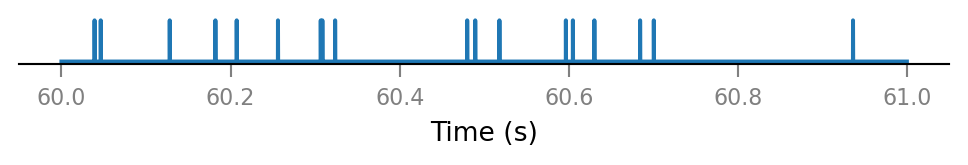

In [11]:
plot_spike_train_excerpt(all_spike_trains[0]);

All connected presynaptic neurons:

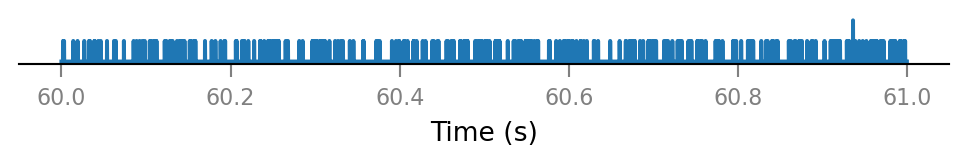

In [12]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

Note that some time bins contain more than one spike.\
(The simulator handles this, by increasing synaptic conductance by an integer multiple of `Δg_syn` in that timebin).

### Synaptic conductance

See the previous notebook {doc}`/notebooks/2020-07-27__Synaptic_conductances` for some more explanation.

In [13]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

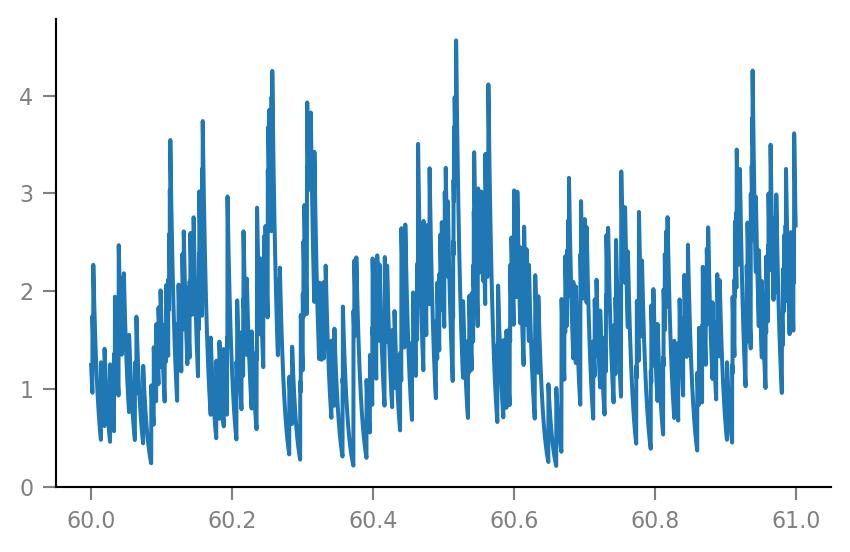

In [14]:
g_syn = v.calc_synaptic_conductance(
    tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice] / nS);

### Membrane voltage

In [15]:
params = v.params.cortical_RS
v.pprint(params)

IzhikevichParams
----------------
C = 1e-10
k = 7e-07
v_r = -0.06
v_t = -0.04
v_peak = 0.035
a = 30.0
b = -2e-09
c = -0.05
d = 1e-10
v_syn = 0.0


In [16]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 222 ms


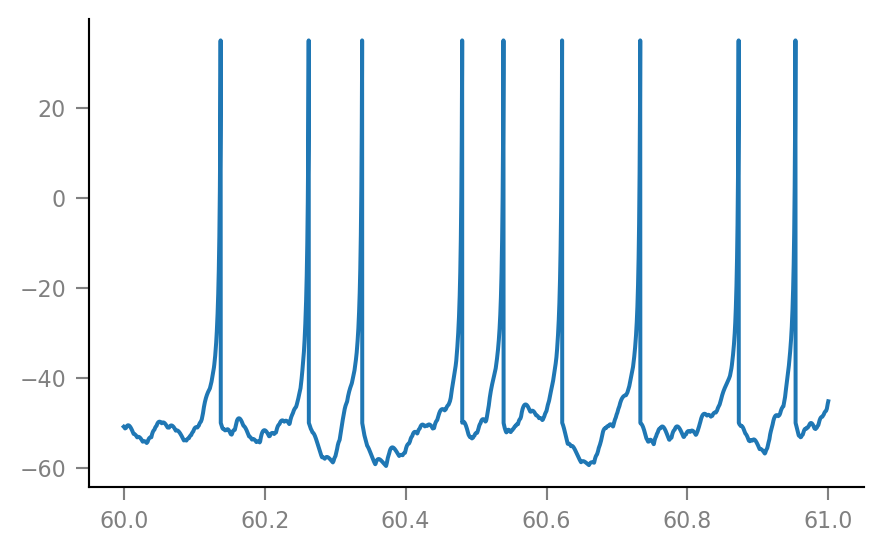

In [17]:
plt.plot(t_slice, sim.V_m[i_slice] / mV);

### Noise

As in {doc}`/notebooks/2020-07-06__Single_neuron_sim`.

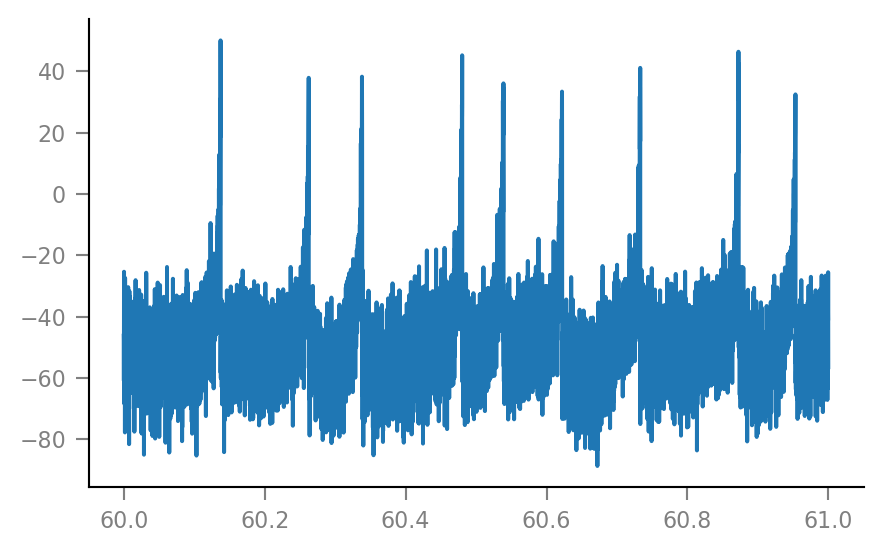

In [18]:
Vm_noisy = v.add_VI_noise(sim.V_m, params)

plt.plot(t_slice, Vm_noisy[i_slice] / mV);

## Shuffle one spike train

We choose one spike train / incoming neuron, and will test the hypothesis that this neuron is connected to the simulated neuron.
- H0 = neuron of incoming spike train is not connected to simulated neuron
- H1 = they _are_ connected

In [19]:
spike_train = all_spike_trains[0];

We will shuffle the real spike train $S$ times to generate $S$ 'fake' spike trains, which have the same number of spikes but at random times.

In [20]:
S = 100;

In [21]:
%%time
shuffled_spike_trains = []
for i in range(S):
    x = spike_train.copy()
    np.random.shuffle(x)  # in-place
    shuffled_spike_trains.append(x)

Wall time: 12.4 s


Inspect a few shuffled spike trains.

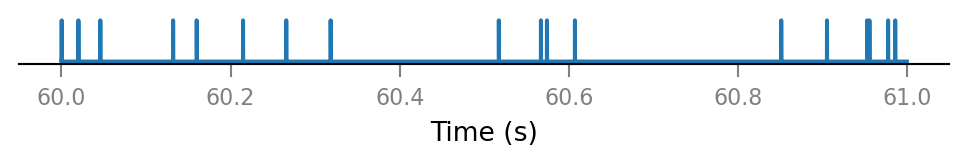

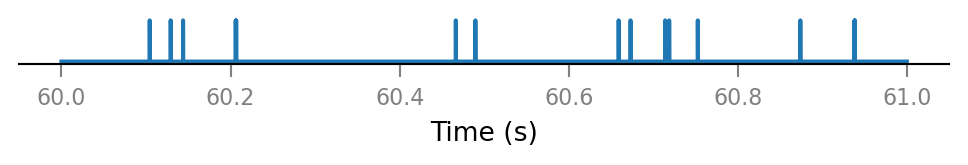

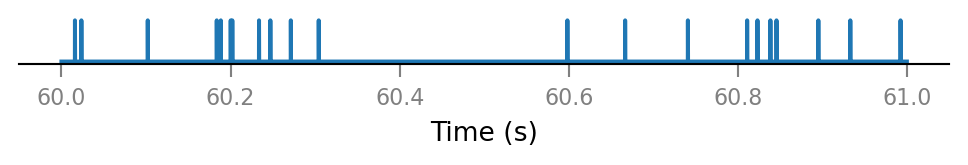

In [22]:
for i in range(3):
    plot_spike_train_excerpt(shuffled_spike_trains[i]);

Real spike train again:

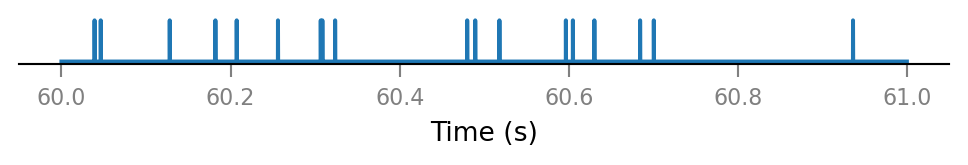

In [23]:
plot_spike_train_excerpt(spike_train);

Same number of spikes in all:

In [24]:
def num_spikes(spike_train):
    spike_indices = v.get_spike_indices(spike_train)
    return len(spike_indices)

In [25]:
for i in range(3):
    print(num_spikes(shuffled_spike_trains[i]))

12020
12020
12020


In [26]:
num_spikes(spike_train)

12020

Spiking frequency of the chosen presynaptic neuron:

In [27]:
num_spikes(spike_train) / tg.T / Hz

20.03

That's to spec.

## Spike-triggered windowing & averaging

For each spike train (original and shuffleds), we extract spike-triggered windows from the simulated voltage imaging signal, and average those windows.

In [28]:
window_length = 100 * ms;

In [29]:
window_tg = v.TimeGrid(window_length, tg.dt);

In [30]:
def calc_STA(spike_train):
    return v.calculate_STA(Vm_noisy, spike_train, tg, window_tg)

In [31]:
original_STA = calc_STA(spike_train);

In [32]:
%%time
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

Wall time: 8.15 s


Plot STA's of the original spike train (top left) and three shuffled spike trains:

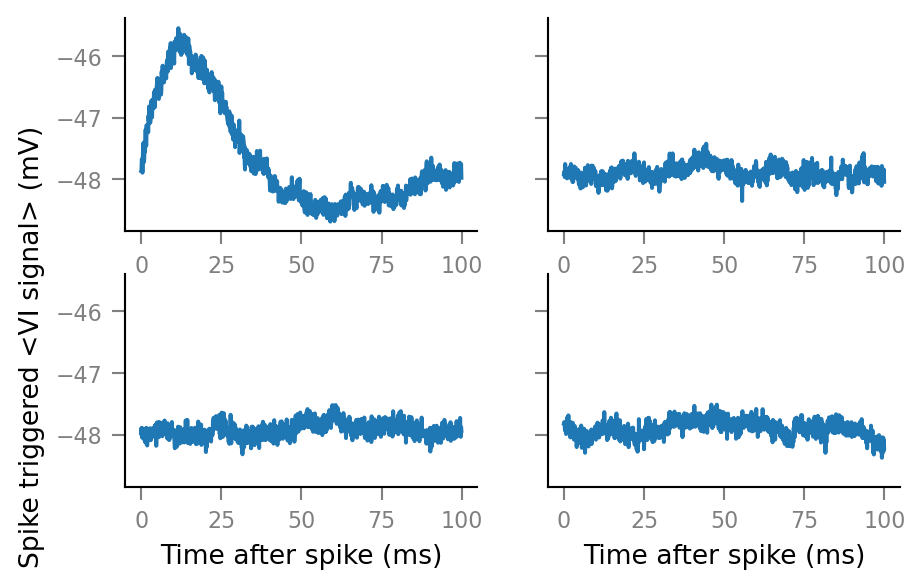

In [33]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True)

original_ax = axes.flat[0]
v.plot_STA(original_STA, window_tg, original_ax)
ylabel = original_ax.yaxis.get_label()
ylabel.set_horizontalalignment('right')


for i in range(3):
    ax = axes.flat[i+1]
    v.plot_STA(shuffled_STAs[i], window_tg, ax)
    ax.set(ylabel=None)

## Peak height of STA

In [34]:
shuffled_STA_peak_heights = []
for STA in shuffled_STAs:
    shuffled_STA_peak_heights.append(np.max(STA))
shuffled_STA_peak_heights = np.array(shuffled_STA_peak_heights);
    # Convert list to numpy array for division or comparison with scalars later.

In [35]:
original_STA_peak_height = np.max(original_STA);

Let's look at the distribution of peak heights.

In [36]:
import seaborn as sns  # Extension of matplotlib for statistical data viz.

Shuffled spike trains only:

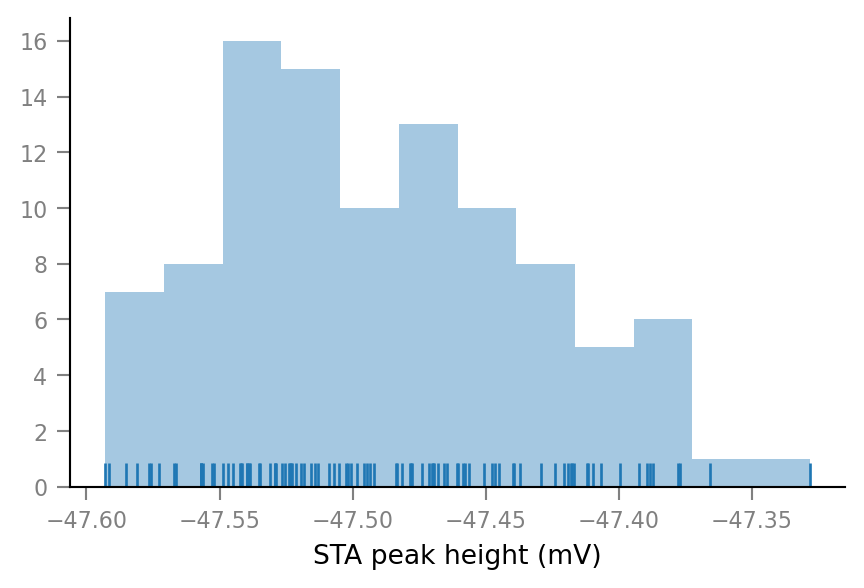

In [37]:
dist_ax = sns.distplot(shuffled_STA_peak_heights / mV, kde=False, rug=True, bins=12)
#   KDE=False means that the y-axis labels give count in each bin. (Otherwise, it's a density).
dist_ax.set_xlabel("STA peak height (mV)");

Add original spike train:

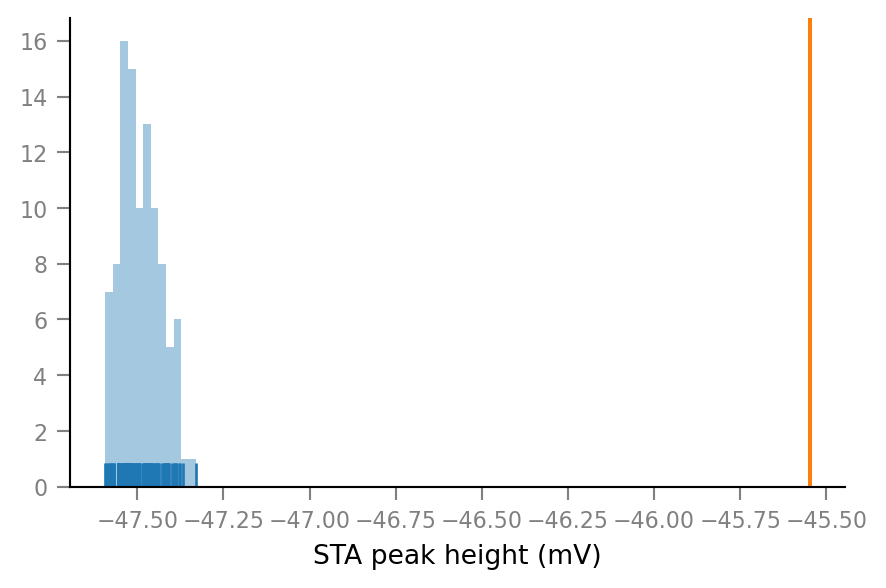

In [38]:
dist_ax.axvline(original_STA_peak_height / mV, color="C1")
dist_ax.figure

## p-value

### As proportion

If we define p-value as proportion of shuffled STA peak heights higher than the original, we get, of course:

In [39]:
p_proportion = np.sum(shuffled_STA_peak_heights > original_STA_peak_height)

0

### As integral of KDE

We can fit a distribution to the H0 peak heights to get another type of p-value.

We choose a kernel-density estimate (KDE), i.e. a non-paramteric distribution (except hyperparams).
(See here for code explanation: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Kernel-Density-Estimation-in-Practice)

In [40]:
from sklearn.neighbors import KernelDensity

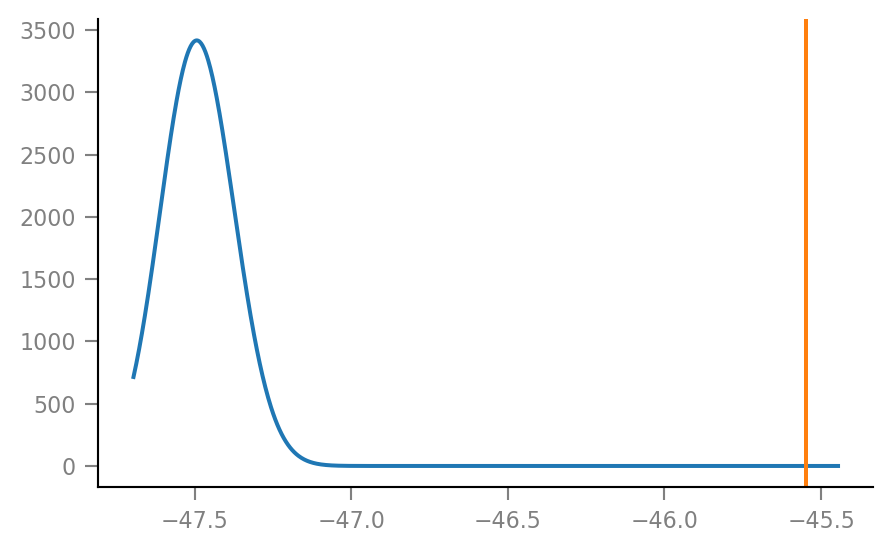

In [92]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.1 * mV)
kde.fit(shuffled_STA_peak_heights[:, np.newaxis])  # `fit` expects 2D array.

def plot_KDE(xrange):  # xrange given in mV
    x = np.linspace(*np.array(xrange) * mV, 1000)[:, np.newaxis]
    y = np.exp(kde.score_samples(x));  # `score_samples` returns log of prob.
    fig, ax = plt.subplots()
    ax.plot(x / mV, y)
    ax.axvline(original_STA_peak_height / mV, color="C1")
    return fig, ax

plot_KDE(dist_ax.get_xlim());

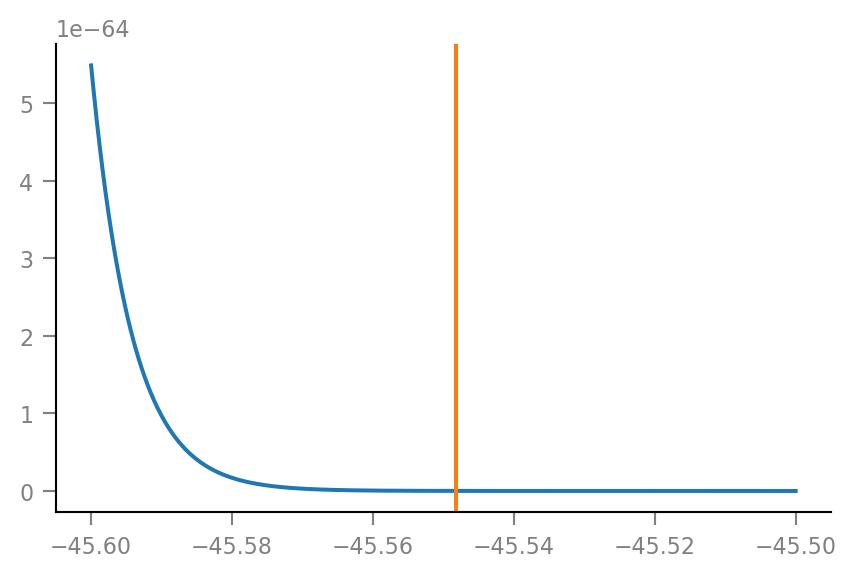

In [96]:
plot_KDE((-45.6, -45.5));

In [76]:
def pdf(x):
    return np.exp(kde.score_samples([[x]])).item()

pdf(original_STA_peak_height)

6.209E-68

p-value is area under the curve to the right of original spike train peak STA height.

In [77]:
from scipy.integrate import quad

Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html

In [100]:
result, error = quad(pdf, a=original_STA_peak_height, b=0 * mV)
(result, error)

(1.099E-75, 2.186E-75)

The absolute error is larger than the estimated integral. The result is thus not reliable.

Anyway, from the plots it's clear that this p-value is very small.

Next steps: describe influence of `N_in`, `p_connected`, `SNR`, … on p-value.

## Repro info

In [89]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Mon 30 Nov** 2020, at 12:03 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/4434b68ced70416bb2a41f589d0d69c772e2bf58
) (Mon 30 Nov 2020, 11:46).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
?? notebooks/2020-11-27__permutation_test.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
